In [1]:
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import delu
import delu.data
import math
import pandas as pd

# settings
device = torch.device('cuda')
delu.improve_reproducibility(base_seed=1024)

# wandb config
config = {
    "learning_rate": 0.0003,
    "epochs": 1000,
    "batch_size": 32,
    "dropout": 0.2,
    "train_split": 0.8,
    "weight_decay": 0.0,
    "patience": 20
}

In [2]:
from torch.utils.data import Dataset

import delu
delu.improve_reproducibility(base_seed=1024)

class drdo_data(Dataset):
    def __init__(self, dataset, dep_variable, train_split, device,
                 all_pp: bool=False, no_pp: bool=False, target_pp: bool=False, feature_pp: bool=False) -> None:
        self.train_split = train_split
        self.device = device
        self.dataset = dataset
        self.dep_variable = dep_variable
        self.df = pd.read_csv(dataset)
        self.X = {}
        self.y = {}

        y_all = self.df[dep_variable].astype('float32').to_numpy()
        X_all = self.df.drop(dep_variable, axis=1).astype('float32').to_numpy()

        self.X['train'], self.X['test'], self.y['train'], self.y['test'] = sklearn.model_selection.train_test_split(
            X_all, y_all, train_size=train_split, random_state=1024)

        self.X['train'], self.X['val'], self.y['train'], self.y['val'] = sklearn.model_selection.train_test_split(
            self.X['train'], self.y['train'], train_size=train_split, random_state=1024)
        
        if all_pp == True:
            preprocess = sklearn.preprocessing.QuantileTransformer()
            preprocess.fit(self.X['train'])
            self.X = {k: torch.tensor(preprocess.transform(v), device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
            self.y_mean = self.y['train'].mean().item()
            self.y_std = self.y['train'].std().item()
            self.y = {k: (v - self.y_mean) / self.y_std for k, v in self.y.items()}
        else:
            pass

        if no_pp == True:
            self.X = {k: torch.tensor(v, device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
        else:
            pass

        if target_pp == True:
            self.X = {k: torch.tensor(v, device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
            self.y_mean = self.y['train'].mean().item()
            self.y_std = self.y['train'].std().item()
            self.y = {k: (v - self.y_mean) / self.y_std for k, v in self.y.items()}
        else:
            pass

        if feature_pp == True:
            preprocess = sklearn.preprocessing.QuantileTransformer()
            preprocess.fit(self.X['train'])
            self.X = {k: torch.tensor(preprocess.transform(v), device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
        else:
            pass

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.X['train'][index], self.y['train'][index]


In [3]:
import pandas as pd
df = pd.read_csv('../../data/SIDI_Full.csv')
df.head(3)

,LD,Velocity (km/s),a (degrees),$ (degrees),DI
0,1,0.25,90,75,0.00007
1,1,0.25,90,60,0.00580
2,1,0.25,90,45,0.01259


In [4]:
feature_pp = drdo_data(
    dataset='../../data/SIDI_Full.csv',
    dep_variable='DI',
    train_split=0.8,
    device=device,
    feature_pp=True)

In [5]:
losses = {'MLP': [], 'FT-T': [], 'ResNet': [], 'NODE': []}

In [6]:
# ResNet
import rtdl

MODEL_NAME = 'ResNet'
data = feature_pp

model = rtdl.ResNet.make_baseline(
    d_in=data.X['train'].shape[1],
    d_main=64,
    d_hidden=64, 
    dropout_first=0.2,
    dropout_second=0.2,
    n_blocks=64,
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    # pred = model(data.X[part])
    target = data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        # loss = loss_fn(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses[f"{MODEL_NAME}"].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 0.4243
Epoch 000 | Validation score: 0.0499 | Test score: 0.0554 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.0149 | Test score: 0.0162 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.0100 | Test score: 0.0127 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.0060 | Test score: 0.0084 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.0045 | Test score: 0.0072 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.0055 | Test score: 0.0072
Epoch 006 | Validation score: 0.0059 | Test score: 0.0070
Epoch 007 | Validation score: 0.0031 | Test score: 0.0042 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0030 | Test score: 0.0037 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0025 | Test score: 0.0030 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0030 | Test score: 0.0032
Epoch 011 | Validation score: 0.0033 | Test score: 0.0037
Epoch 012 | Validation score: 0.0033 | Test score: 0.0037
Epo

In [7]:
# MLP
import rtdl

MODEL_NAME = 'MLP'
data = feature_pp

model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    # pred = model(data.X[part])
    target = data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        # loss = loss_fn(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses[f"{MODEL_NAME}"].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 0.3282
Epoch 000 | Validation score: 0.0952 | Test score: 0.0849 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.0697 | Test score: 0.0609 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.0474 | Test score: 0.0431 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.0291 | Test score: 0.0282 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.0178 | Test score: 0.0188 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.0127 | Test score: 0.0150 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.0095 | Test score: 0.0118 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.0082 | Test score: 0.0109 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0069 | Test score: 0.0093 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0064 | Test score: 0.0086 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0058 | Test score: 0.0079 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.0056 | Te

In [9]:
# NODE
MODEL_NAME = 'NODE'
data = feature_pp

from model_classes import node_lib
model = torch.nn.Sequential(
    node_lib.DenseBlock(4, 2048, num_layers=1, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=node_lib.entmax15, bin_function=node_lib.entmoid15),
    node_lib.Lambda(lambda x: x[..., 0].mean(dim=-1)))

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    # pred = model(data.X[part]).squeeze(1)
    pred = model(data.X[part])
    target = data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        # loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss = loss_fn(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses[f"{MODEL_NAME}"].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 0.2254
Epoch 000 | Validation score: 0.2164 | Test score: 0.2103 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.2025 | Test score: 0.1962 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.1895 | Test score: 0.1831 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.1773 | Test score: 0.1708 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.1659 | Test score: 0.1593 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.1552 | Test score: 0.1485 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.1450 | Test score: 0.1383 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.1355 | Test score: 0.1287 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.1265 | Test score: 0.1196 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.1180 | Test score: 0.1111 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.1099 | Test score: 0.1031 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.1024 | Te

In [11]:
# FT-T
import rtdl

MODEL_NAME = 'FT-T'
data = feature_pp

model = rtdl.FTTransformer.make_default(
    n_num_features=data.X['train'].shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part], x_cat=None).squeeze(1)
    # pred = model(data.X[part])
    target = data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch, x_cat=None).squeeze(1), y_batch)
        # loss = loss_fn(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses[f"{MODEL_NAME}"].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

Test score before training: 0.6346
Epoch 000 | Validation score: 0.0289 | Test score: 0.0282 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.0056 | Test score: 0.0072 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.0041 | Test score: 0.0044 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.0026 | Test score: 0.0028 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.0029 | Test score: 0.0031
Epoch 005 | Validation score: 0.0051 | Test score: 0.0051
Epoch 006 | Validation score: 0.0026 | Test score: 0.0028
Epoch 007 | Validation score: 0.0021 | Test score: 0.0022 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0018 | Test score: 0.0019 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0019 | Test score: 0.0020
Epoch 010 | Validation score: 0.0018 | Test score: 0.0019
Epoch 011 | Validation score: 0.0036 | Test score: 0.0036
Epoch 012 | Validation score: 0.0016 | Test score: 0.0018 <<< BEST VALIDATION EPOCH
Epoch 013 | Validation score:

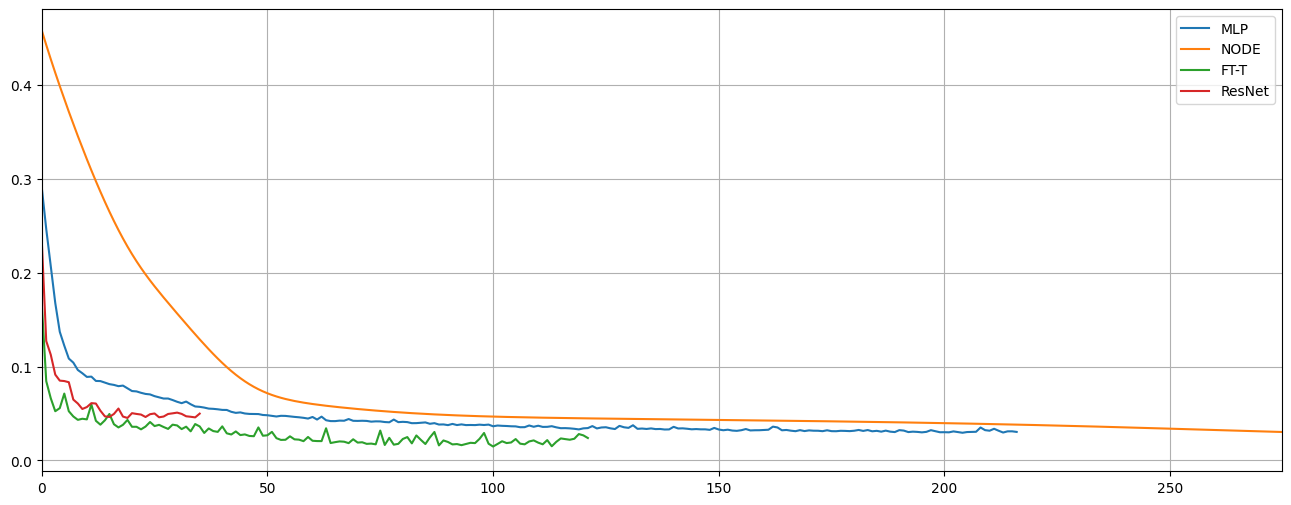

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(losses['MLP'], label='MLP')
plt.plot(losses['NODE'], label='NODE')
plt.plot(losses['FT-T'], label='FT-T')
plt.plot(losses['ResNet'], label='ResNet')
plt.legend()
plt.grid()

x_min, x_max = plt.xlim()
plt.xlim(0, (x_max-x_min)/4)

plt.show()

In [19]:
print(f"losses['FT-T']: {losses['FT-T'][-1]:.4f}")
print(f"losses['ResNet']: {losses['ResNet'][-1]:.4f}")
print(f"losses['NODE']: {losses['NODE'][-1]:.4f}")
print(f"losses['MLP']: {losses['NODE'][-1]:.4f}")

losses['FT-T']: 0.0240
losses['ResNet']: 0.0500
losses['NODE']: 0.0109
losses['MLP']: 0.0109
